Test with Acropora abrolhosensis https://www.marinespecies.org/aphia.php?p=taxdetails&id=288182
aphiaID = 288182  
urn = urn:lsid:marinespecies.org:taxname:288182

In [1]:
import json
from urllib.request import urlopen
import urllib.parse
import pandas as pd

Build OBIS API query

In [2]:
base = 'https://api.obis.org/v3/'

aphiaID = '342218'

fields = ['decimalLatitude','decimalLongitude','occurrenceID','id',
          'datasetName','dataset_id','eventDate','species','aphiaID',
          'date_year']

f = "%2C".join([f"{v}" for v in fields])

# define a polygon
# bound it somehow to between 30 deg N and S latitude
#geometry=urllib.parse.quote("POLYGON ((-180 -30, 180 -30, 180 30, -180 30, -180 -30))")

#depth = [0, 30]

# How many responses do you want back? Max=10000
size = 10000

#occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&size={}'.format(aphiaID,depth[0],depth[1],geometry,size)
occurrence_id = 'occurrence?taxonid={}&size={}'.format(aphiaID,size)


#taxon_id = 'taxon/{}'.format(aphiaID)
#taxon_sn = 'taxon/{}'.format(scientificname)

url = '{}{}'.format(base,occurrence_id)

url

'https://api.obis.org/v3/occurrence?taxonid=342218&size=10000'

Download the data from OBIS API into pandas DataFrame

In [3]:
response= urlopen(url)

data_json = json.loads(response.read())

data = pd.DataFrame(data_json['results'])

size = data_json['total']

print("Found %i records." % size)
print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?',occurrence_id.replace("occurrence?","")))

Found 221 records.
See in mapper at: https://mapper.obis.org/?taxonid=342218&size=10000#


Save DataFrame as GeoDataFrame

In [4]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs="EPSG:4326")

Bin to 1 degree cells

bin to one degree cells across globe

In [5]:
import numpy as np
import shapely

# total area for the grid
xmin, ymin, xmax, ymax= [-180., -90., 180., 90]
# how many cells across and down
n_cells=360
cell_size = (xmax-xmin)/n_cells
# projection of the grid
#crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs="EPSG:4326")
    
# ax = gdf.plot(markersize=.1, figsize=(12, 8),)# column='dob', cmap='jet')
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

merged = gpd.sjoin(gdf, cell, how='left', op='within')

# make a simple count variable that we can sum
merged['n_occur'] = 1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_occur'] = dissolve.n_occur.values

cell = cell[~cell['n_occur'].isna()]

cell['area (km2)'] = cell.to_crs(epsg=3763).area/(1000**2)

cell['density (#/km2)'] = cell['n_occur']/cell['area (km2)']

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
cell[['n_occur','density (#/km2)']]

,n_occur,density (#/km2)
226,1.0,0.000112
408,1.0,0.000110
590,3.0,0.000322
1313,1.0,0.000108
2226,1.0,0.000092
...,...,...
64844,1.0,0.000111
65020,1.0,0.000121
65021,1.0,0.000119
65206,1.0,0.000110


Now make the plot using geopandas built in plot

(-18491143.68863403, 18491143.68863403, -9473562.580980353, 9191411.568387408)

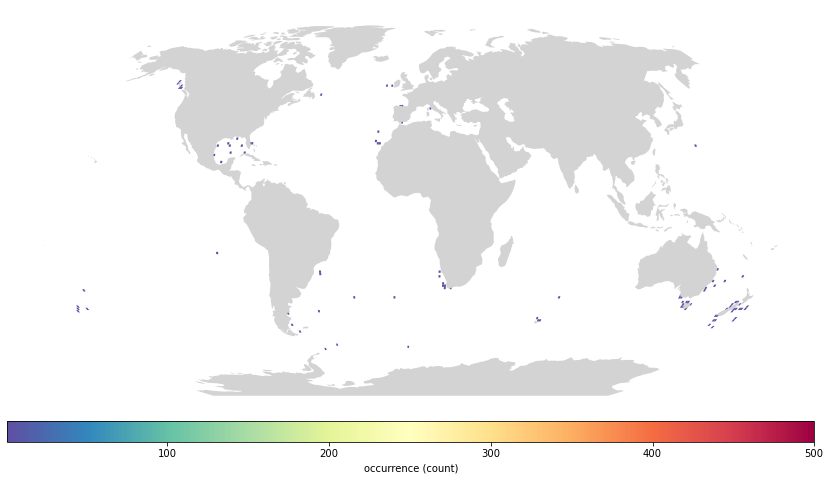

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pycrs
import geoplot as gplt

crs = pycrs.parse.from_esri_code(54030)
#crs.geogcs.prime_mer.value = 160.0
crs_str = crs.to_proj4()

#fig, ax = plt.subplots(figsize=(16,8), facecolor='white')
#ax = plt.subplot(1, 4, 4, figsize=(16,8))

fig = plt.figure(figsize=(16, 8))

#mol = ccrs.Mollweide()
ax = fig.add_subplot(1, 1, 1,)

# start map with entire world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

# world.to_crs(crs_str).plot( ax=ax,
#                             color='lightgrey', 
#                             edgecolor=None,
#                             linewidth=None
#                             )

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# plot the gridded occurrence cells
cell.to_crs(crs_str).plot( ax=ax,
                           column='n_occur', 
                           cmap='Spectral_r', 
                           vmin=1, 
                           vmax=500, 
                           edgecolor=None, 
                           legend=True,
                           legend_kwds={'label': "occurrence (count)",
                                        'orientation': "horizontal"},
                           cax=cax,
                           )

plt.autoscale(False)

world.to_crs(crs_str).plot( ax=ax,
                            color='lightgrey', 
                            edgecolor=None,
                            linewidth=None
                            )

#ax.outline_patch.set_visible(True)
#world.to_crs("ESRI:54009").plot(ax=ax, color='none', edgecolor='black',linewidth=.5)
ax.axis('off')
#plt.grid(True)

Use geoplot

C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_21024/2391497815.py:71: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(True)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:180: ShapelyDeprecationWar

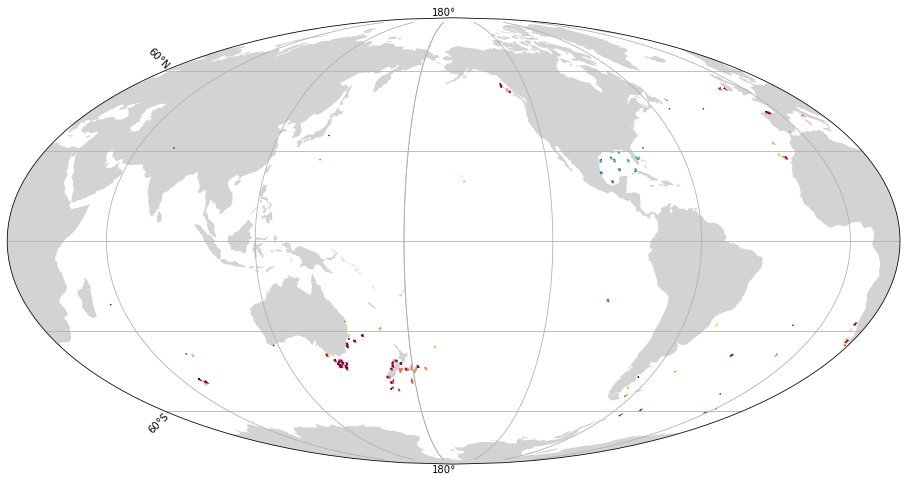

In [25]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


norm = mpl.colors.Normalize(vmin=0, vmax=0.000142)

projection=gcrs.Mollweide(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

#fig, ax = plt.subplots(figsize=(16,16), facecolor='white', subplot_kw={'projection':projection})

ax = geoplot.polyplot(
    world,
    figsize=(16,16),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
   # ax=ax,
)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.1)

#cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

# cell[~cell['n_occur'].isna()]

#cell = cell[~cell['n_occur'].isna()]



geoplot.choropleth(cell, 
                   hue='density (#/km2)', 
                   #edgecolor='black', 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
#                    legend=True,
#                    legend_kwargs={'orientation': 'horizontal',
#                                   #'cax':cax,
#                                   'label':"occurrence (count)",
#                                  },
                   norm=norm, 
                  )


geoplot.pointplot(gdf, ax=ax, projection=projection, color='black', s=.5)

# import cartopy.crs as ccrs

# gl = ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, crs=ccrs.PlateCarree())
# gl.ylocator = mticker.FixedLocator(range(-90,91,30)) #-75, -50, -25, 0, 25, 50, 75, 90])
# gl.xlocator = mticker.FixedLocator(range(-180,181,30)) #-75, -50, -25, 0, 25, 50, 75, 90])
# gl.top_labels = False
# gl.bottom_labels = True
# gl.left_labels = False
# gl.right_labels = True
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)


ax.outline_patch.set_visible(True)
ax.set_global(); 

order = [0,2,1,3]
extent = [cell.total_bounds[i] for i in order]

#ax.set_extent(extent)

In [9]:
extent

[-180.0, 180.0, -62.0, 55.0]

In [10]:
print("records:",data.shape[0])
print("Years: %i - %i" % (data["date_year"].astype(float).min(),data["date_year"].astype(float).max()))
print("Species:", len(data['species'].dropna().unique()))
print("Taxa:", len(data['aphiaID'].dropna().unique()))

records: 221
Years: 1871 - 2020
Species: 1
Taxa: 1


Create a histogram by year

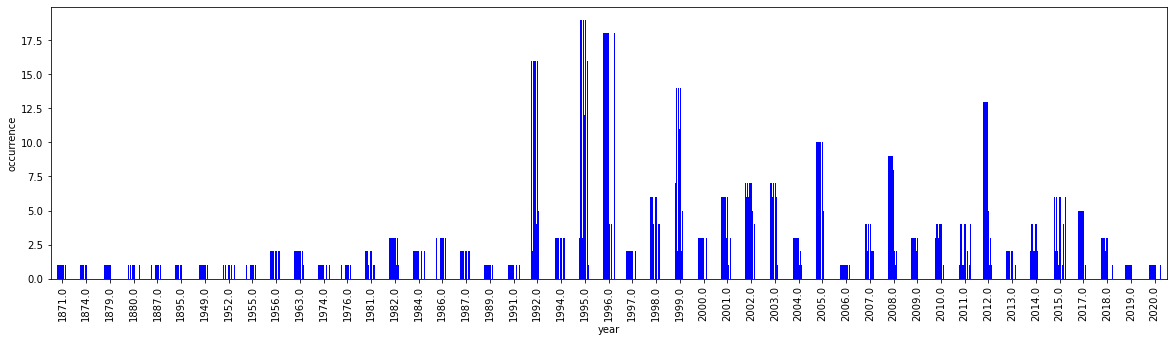

In [11]:
import matplotlib as plt

data['date'] = pd.to_datetime(data['date_year'],format="%Y")

year_group = data.groupby(data['date'].dt.year)

ax = year_group.count().plot(kind="bar", 
                             color='blue',
                             legend=False, 
                             figsize=(20, 5),
                             ylabel='occurrence',
                             xlabel='year',
                            )

#ax.xaxis.set_major_locator(plt.ticker.MaxNLocator(1))

Create a histogram by latitude

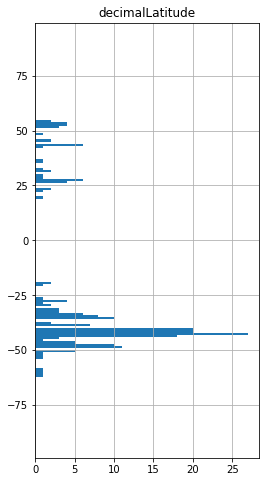

In [12]:
import matplotlib.pyplot as plt
bins = [i for i in range(-90, 91, 1)]

fig, ax = plt.subplots(figsize=(4,8))

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal', ax=ax)
plt.xlabel='occurrence (count)'
plt.title=''
# latitude_group = cell.groupby('n_occur')
# latitude_group['n_occur'].count().plot()

Combine the map and histogram

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
C:\Users\MATHEW~1.BID\AppData\Local\Temp\9/ipykernel_5104/1884796911.py:49: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.set_global(); ax.outline_patch.set_visible(True);


array([<Axes:title={'center':'decimalLatitude'}>], dtype=object)

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\numpy\lib\function_base.py:5392: ShapelyDe

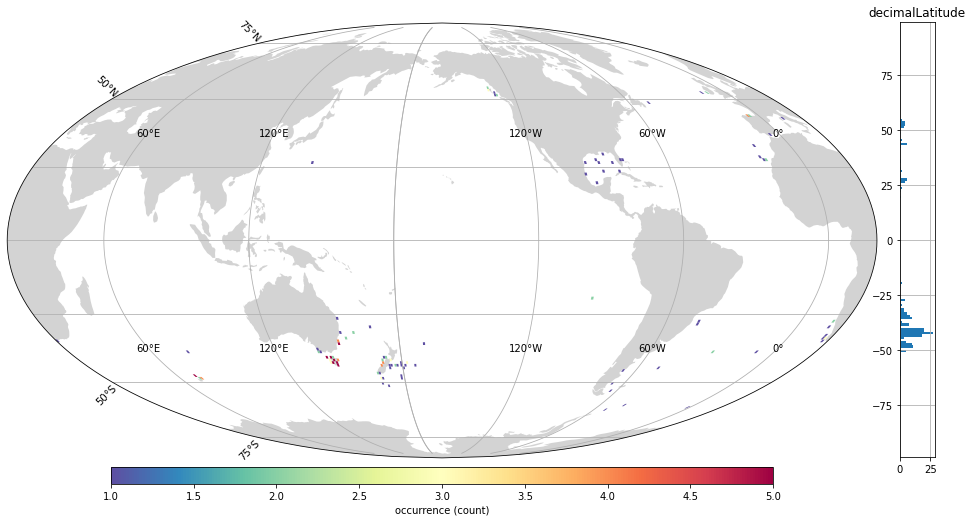

In [13]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=5)

projection=gcrs.Mollweide(central_longitude=-160)
#projection=gcrs.Robinson(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

fig, ax = plt.subplots(figsize=(16,8), facecolor='white', subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    figsize=(16,8),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.1)

cax = fig.add_axes([0.225, 0.08, 0.575, 0.03])

# cell[~cell['n_occur'].isna()]

cell = cell[~cell['n_occur'].isna()]

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                  )

ax.set_global(); ax.outline_patch.set_visible(True); 

import matplotlib.ticker as mticker

gl = ax.gridlines(draw_labels=True)
gl.ylocator = mticker.FixedLocator([-90, -75, -50, -25, 0, 25, 50, 75, 90])

# [0.91, 0.125, 0.03, 0.7555]

ax2 = fig.add_axes([0.91, 0.1257, 0.03, 0.7555])

bins = [i for i in range(-90, 91, 1)]

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal', ax=ax2, )
#data = gdf.to_crs(projection)
#count, lat = pd.np.histogram(data['decimalLatitude'], bins=bins)

#ax2.plot(count,lat[:-1])

#ax2.sharey(ax)

#yticks = ax.yaxis.get_major_ticks()

#ax2.set_yticks(yticks)

#plt.title('')

In [14]:
cell.explore()

# Make subplot w/ regions of interest as one figure

C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_21024/4097728497.py:61: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax0.outline_patch.set_visible(True)
C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_21024/4097728497.py:117: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_visible(True)
C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_21024/4097728497.py:173: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax2.outline_patch.set_visible(True)
C:\Users\MATHEW~1.BID\AppData\Local\Temp\11/ipykernel_21024/4097728497.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbo

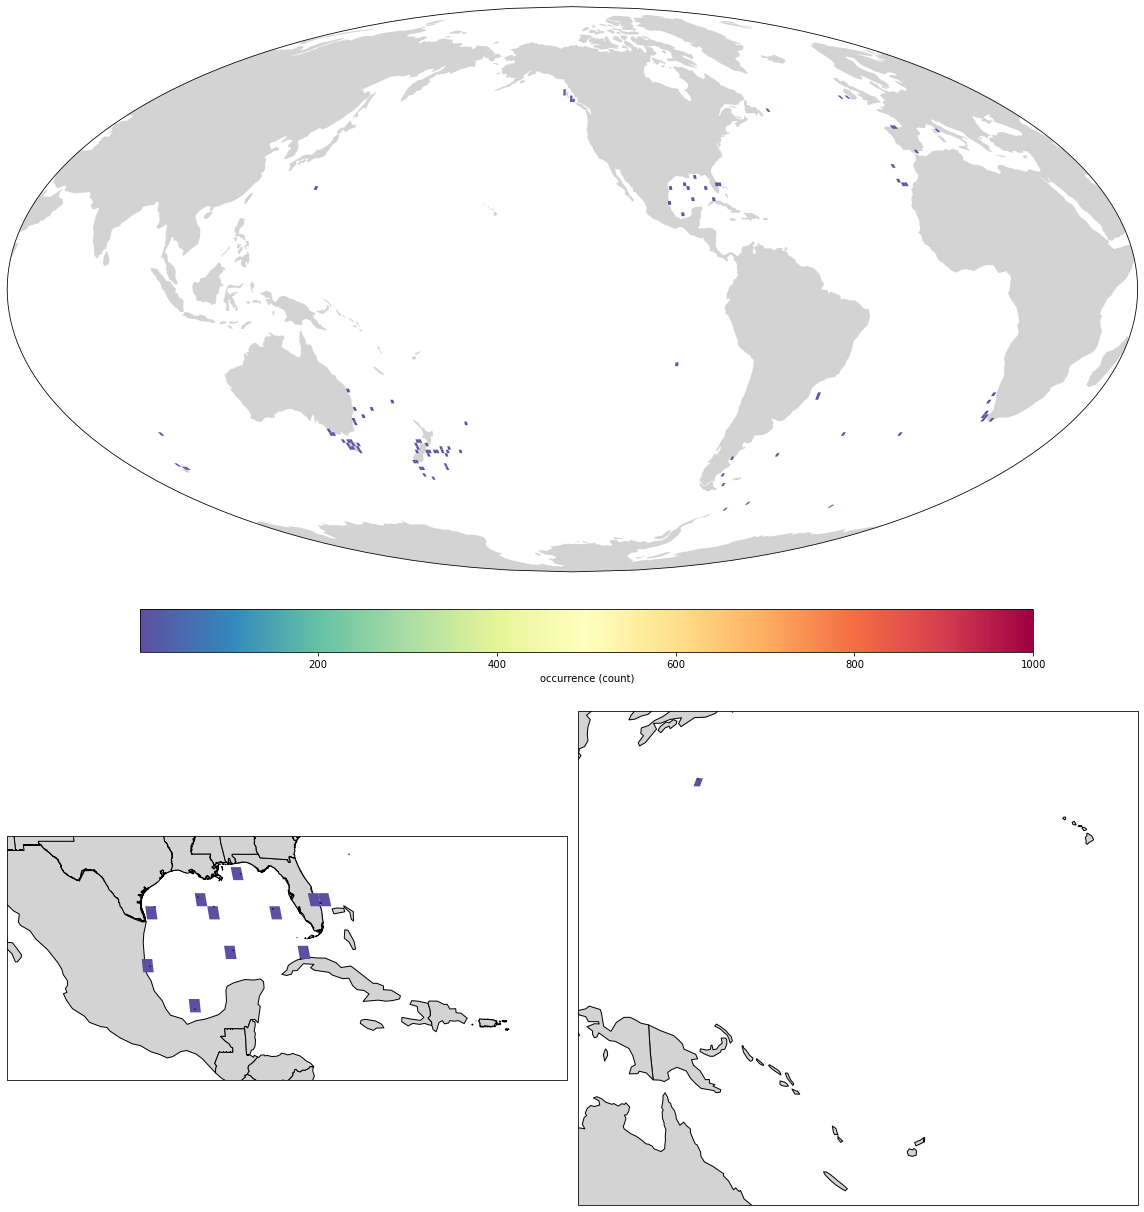

In [7]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def identity_scale(minval, maxval):
    def scalar(val):
        return 0.5
    return scalar

wms = 'https://gis.unep-wcmc.org/arcgis/services/marine/WCMC_008_CoralReefs_WMS/MapServer/WMSServer?request=GetCapabilities&service=WMS'

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

projection=gcrs.Mollweide(central_longitude=-130)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

continental_usa = gpd.read_file('./data/cb_2018_us_state_500k.shp')

joined = world.append(continental_usa.rename(columns={'NAME':'name'}))


fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,20), facecolor=None, subplot_kw={'projection':projection})


# making top subplot span 2 cols
gs = ax[0, 1].get_gridspec()
# remove the underlying axes
for a in ax[0, :]:
    a.remove()
ax0 = fig.add_subplot(gs[0, :], projection=projection)
ax1 = ax[1,0]
ax2 = ax[1,1]


geoplot.polyplot(
    world.dissolve(),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax0,
)

cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax0,
                   cmap='Spectral_r',
                   legend=False,
                   norm=norm, 
                  )

ax0.set_global(); 

ax0.outline_patch.set_visible(True)

# New subplot for carribean

projection=gcrs.Mollweide(central_longitude=-90)

# geoplot.polyplot(
#     world[world.name!="United States of America"],
#     facecolor='lightgray',
#     edgecolor='black',
#     projection=projection,
#     ax=ax1,
# )

geoplot.polyplot(
    joined,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax1,
)

# or define your own as a list [xmin, xmax, ymin, ymax]
extent = [-110, -60, 14, 30]

ax1.set_extent(extent)

# ax1.add_wms(wms=wms,
#           layers=['0','1'],
#           zorder=5,
#           )

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax1,
                   cmap='Spectral_r',
                   legend=False,
                   norm=norm, 
                   zorder=2,
                  )

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax1,
)

ax1.set_extent(extent)

ax1.outline_patch.set_visible(True)

ax1

# New subplot for Pacific region

projection=gcrs.Mollweide(central_longitude=-189)

geoplot.polyplot(
    world,
    facecolor='lightgray',
    edgecolor='black',
    projection=projection,
    ax=ax2,
)

# define your own as a list [xmin, xmax, ymin, ymax]
extent = [-230, -149, -19, 29]

ax2.set_extent(extent)

# ax2.add_wms(wms=wms,
#           layers=['0','1'],
#           zorder=5,
#           )

cax = fig.add_axes([0.125, 0.48, 0.775, 0.03])

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax2,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                   zorder=2,
                  )

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax2,
)

ax2.set_extent(extent)

ax2.outline_patch.set_visible(True)

fig.tight_layout()

In [38]:
continental_usa[continental_usa.NAME=='Hawaii'].centroid

C:\Users\MATHEW~1.BID\AppData\Local\Temp\10/ipykernel_8492/842126075.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  continental_usa[continental_usa.NAME=='Hawaii'].centroid


42    POINT (-156.36302 20.25471)
dtype: geometry

In [24]:
continental_usa

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


C:\Users\MATHEW~1.BID\AppData\Local\Temp\10/ipykernel_8492/2103999159.py:51: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(True)
C:\Users\MATHEW~1.BID\AppData\Local\Temp\10/ipykernel_8492/2103999159.py:58: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  continental_usa['centroid']=continental_usa['geometry'].centroid
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:2

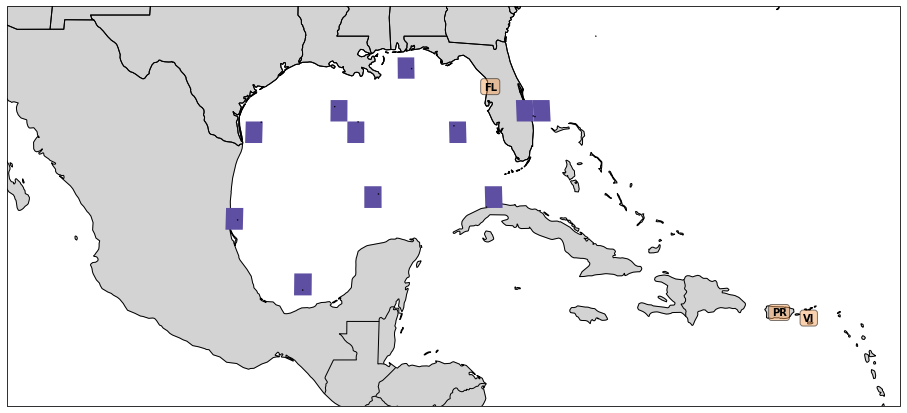

In [142]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(16,20), facecolor=None, subplot_kw={'projection':projection})

projection=gcrs.Mollweide(central_longitude=-90)

# geoplot.polyplot(
#     world[world.name!="United States of America"],
#     facecolor='lightgray',
#     edgecolor='black',
#     projection=projection,
#     ax=ax1,
# )


# or define your own as a list [xmin, xmax, ymin, ymax]
extent = [-110, -60, 14, 30]

ax.set_extent(extent)

# ax1.add_wms(wms=wms,
#           layers=['0','1'],
#           zorder=5,
#           )

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=False,
                   norm=norm, 
                   zorder=2,
                  )

geoplot.pointplot(
    gdf,
    scale=gdf.index,
    scale_func=identity_scale,
    color='black',
    edgecolor=None,
    projection=projection,
    zorder=10,
    ax=ax,
)

ax.set_extent(extent)

ax.outline_patch.set_visible(True)

ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, )
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.STATES, linestyle='-')

continental_usa['centroid']=continental_usa['geometry'].centroid

for index,state in continental_usa.iterrows():
    state_str=state['STUSPS']
    
    if state_str in ["FL","VI","PR"]:
        centroid=state["centroid"]
        ax.text(centroid.x, centroid.y, state_str, 
                verticalalignment='center', 
                horizontalalignment='center',
                transform=ccrs.Geodetic(), 
                fontdict={'fontweight':'semibold'},
                bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
    
#ax.set_extent(extent)
    
# ax.text(-82, 28, 'FL',transform=ccrs.Geodetic())
# ax.text(-64.80205, 17.96902, 'USVI', transform=ccrs.Geodetic())
# ax.text(-66.8, 18, 'PR', transform=ccrs.Geodetic())

In [149]:
continental_usa[continental_usa.NAME=="United States Virgin Islands"]['geometry'].centroid

C:\Users\MATHEW~1.BID\AppData\Local\Temp\10/ipykernel_8492/3498506478.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  continental_usa[continental_usa.NAME=="United States Virgin Islands"]['geometry'].centroid


38    POINT (-64.80205 17.96902)
dtype: geometry

In [124]:
centroid.x

-89.66520804771147

In [120]:
for index,state in continental_usa.iterrows():
    print(state['geometry'])

MULTIPOLYGON (((-88.502966 30.215235, -88.491759 30.209014, -88.46866799999999 30.203731, -88.45344399999999 30.201236, -88.4491297949387 30.2016670206725, -88.44265399999999 30.202314, -88.43033199999999 30.208548, -88.42012099999999 30.209098, -88.41308699999999 30.206344, -88.42925 30.200387, -88.44885549161519 30.1973317760772, -88.453654 30.196584, -88.493523 30.205945, -88.502752 30.210506, -88.50699899999999 30.214348, -88.502966 30.215235)), ((-88.58458999999999 30.337358, -88.583963 30.338138, -88.582703 30.338759, -88.58103799999999 30.338371, -88.579509 30.338837, -88.578744 30.338837, -88.576449 30.338371, -88.575594 30.338177, -88.57446899999999 30.33938, -88.57177 30.340856, -88.56988 30.341322, -88.5697 30.33907, -88.569025 30.337012, -88.56871 30.335885, -88.568395 30.333478, -88.56812499999999 30.332895, -88.56816999999999 30.330293, -88.56776599999999 30.329556, -88.568395 30.328857, -88.56934 30.328818, -88.572895 30.328895, -88.575594 30.329323, -88.579509 30.329866

POLYGON ((-109.060253 38.599328, -109.059541 38.719888, -109.057388 38.795456, -109.054189 38.874984, -109.053943 38.904414, -109.053797 38.905284, -109.053233 38.942467, -109.053292 38.942878, -109.052436 38.999985, -109.05229247355 39.0195738751214, -109.052272287312 39.0223289470262, -109.051582259727 39.1165057639044, -109.051512 39.126095, -109.050765 39.366677, -109.051199943037 39.46195498172, -109.051363 39.497674, -109.051362941959 39.4977032760106, -109.051040251034 39.66047064935179, -109.050615 39.87497, -109.050873 40.058915, -109.050813 40.059579, -109.05093571823 40.173054017608, -109.050944 40.180712, -109.050973 40.18084899999999, -109.050968717402 40.2226470020202, -109.050946 40.444368, -109.050314 40.495092, -109.050698 40.499963, -109.049955 40.539901, -109.050061265437 40.5403090949957, -109.050074 40.540358, -109.048044 40.619231, -109.048249 40.65360099999999, -109.048372974241 40.662608858969, -109.049088 40.714562, -109.048455 40.82608099999999, -109.050076 41

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [117]:
state

'MS'

In [134]:
continental_usa.loc[38]

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\pandas\io\formats\printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a mu

STATEFP                                                    78
STATENS                                              01802710
AFFGEOID                                          0400000US78
GEOID                                                      78
STUSPS                                                     VI
NAME                             United States Virgin Islands
LSAD                                                       00
ALAND                                               348021896
AWATER                                             1550236201
geometry    (POLYGON ((-64.62798599999999 17.789326, -64.6...
centroid         POINT (-64.80204948755335 17.96902023440892)
Name: 38, dtype: object